# Homework 02: Multi-Class Classification with Neural Networks

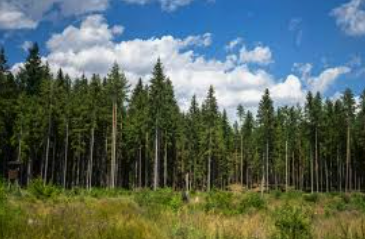

In this assignment, you’ll extend your Keras classification toolkit by training a neural network on a **balanced subset of the Forest Cover (Covertype) dataset**. We’ll begin with a simple baseline network, then study how performance changes as we vary **batch size**, **learning rate**, and apply a **cosine-decay schedule**.

For each configuration, you will consider a range of hyperparameter values, plot training/validation **loss** and **accuracy** over epochs, and determine which choice gave the best performance. 

Finally, you will consider all that you have learned and build your best model and run it on the test set. 


There are 9 graded questions, each worth 9 points, and you get 4 points for free if you complete the whole homework. 


In [31]:
# Useful imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

random_seed = 42

tf.random.set_seed(random_seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

In [32]:
import sys
!{sys.executable} -m pip install -U pillow
!{sys.executable} -m pip install -U scikit-learn
!{sys.executable} -m pip install -U requests


Looking in indexes: https://repo.forge.lmig.com/api/pypi/python/simple
Looking in indexes: https://repo.forge.lmig.com/api/pypi/python/simple
Looking in indexes: https://repo.forge.lmig.com/api/pypi/python/simple


$$k\cdot\sigma$$

In [33]:
# Utility function: Plotting Training Loss (categorical x-entropy) and Accuracy

# Takes the history object returned by fit

def plot_history(history):
    n_epochs = len(history.history['accuracy'])
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(7, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss (Xent)', color='tab:red')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    final_loss = history.history['loss'][-1]
    final_acc = history.history['accuracy'][-1]
    print(f'Final Training Loss:     {final_loss:.4f}')
    print(f'Final Training Accuracy: {final_acc:.4f}')

## Load the dataset

The dataset is described in detail in the Appendix. For the purposes of this homework, we are selecting a random sample with 2747 samples in each class (to preserve balance), because the original dataset is both very large and very imbalanced, with the smallest class having 2747 samples. 

In [34]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np

# Load
X, y = fetch_covtype(return_X_y=True)   # y in {1..7}
classes, counts = np.unique(y, return_counts=True)
min_count = counts.min()                # size of rarest class (~2.7k)

# Build perfectly balanced subset (no replacement, no duplicates)
rng = np.random.default_rng(42)
idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = X[idx_bal]
y_sub = y[idx_bal] - 1                  # relabel to 0..6 for Keras
print("Subset shape:", X_sub.shape, "Class counts:", Counter(y_sub))


Subset shape: (19229, 54) Class counts: Counter({np.int32(3): 2747, np.int32(2): 2747, np.int32(6): 2747, np.int32(5): 2747, np.int32(4): 2747, np.int32(1): 2747, np.int32(0): 2747})


## Problem One: Prepare the dataset and build a baseline model

### Part A: Stratified train/test split and standardization

As in Homework 1, follow these steps:

1. **Stratified split:**
   Use `train_test_split` with `stratify=y_sub` to preserve class proportions in both training and test sets. Be sure to set `random_state=random_seed` and `test_size=0.2`.

2. **Standardize features:**
   Scale the input features so they have mean 0 and variance 1.



In [35]:
# Your code here
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X_sub, y_sub,
    test_size=0.2,
    random_state=random_seed,
    stratify=y_sub
)

# (Optional) sanity check stratification
print("Full:", Counter(y_sub))
print("Train:", Counter(y_train))
print("Test:", Counter(y_test))

# Standardize AFTER split (avoid leakage)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)   # fit on train only
X_test_std  = scaler.transform(X_test)        # transform test using train stats


Full: Counter({np.int32(3): 2747, np.int32(2): 2747, np.int32(6): 2747, np.int32(5): 2747, np.int32(4): 2747, np.int32(1): 2747, np.int32(0): 2747})
Train: Counter({np.int32(5): 2198, np.int32(1): 2198, np.int32(0): 2198, np.int32(2): 2198, np.int32(6): 2197, np.int32(3): 2197, np.int32(4): 2197})
Test: Counter({np.int32(3): 550, np.int32(4): 550, np.int32(6): 550, np.int32(1): 549, np.int32(0): 549, np.int32(5): 549, np.int32(2): 549})


### Part B: Build, compile, train, and evaluate the network

1. **Build the model**

   * Use 2 hidden layers:  input &rarr; 64 &rarr; 32 &rarr; output.
   * Apply the `relu` activation for the hidden layers and `softmax` for the output layer.

2. **Compile the model**

    * Use the following parameters


           optimizer = Adam(learning_rate=0.0001),  
           loss = 'sparse_categorical_crossentropy',  
           metrics = ['accuracy']


4. **Train the model**

   * Run for **20 epochs**.
   * Use a `batch_size` of 32.

5. **Evaluate training**

   * Plot the training loss and accuracy curves using `plot_history`.

6. **Answer the graded questions**



Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2859 - loss: 1.7909 - val_accuracy: 0.4561 - val_loss: 1.5541
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5356 - loss: 1.3530 - val_accuracy: 0.5931 - val_loss: 1.1875
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6026 - loss: 1.0791 - val_accuracy: 0.6126 - val_loss: 0.9944
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6181 - loss: 0.9512 - val_accuracy: 0.6360 - val_loss: 0.9054
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6351 - loss: 0.8883 - val_accuracy: 0.6516 - val_loss: 0.8542
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6523 - loss: 0.8492 - val_accuracy: 0.6724 - val_loss: 0.8198
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6676 - loss: 0.8212 - val_accuracy: 0.6893 - val_loss: 0.7942
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6780 - loss: 0.7993 - val_accuracy: 0.

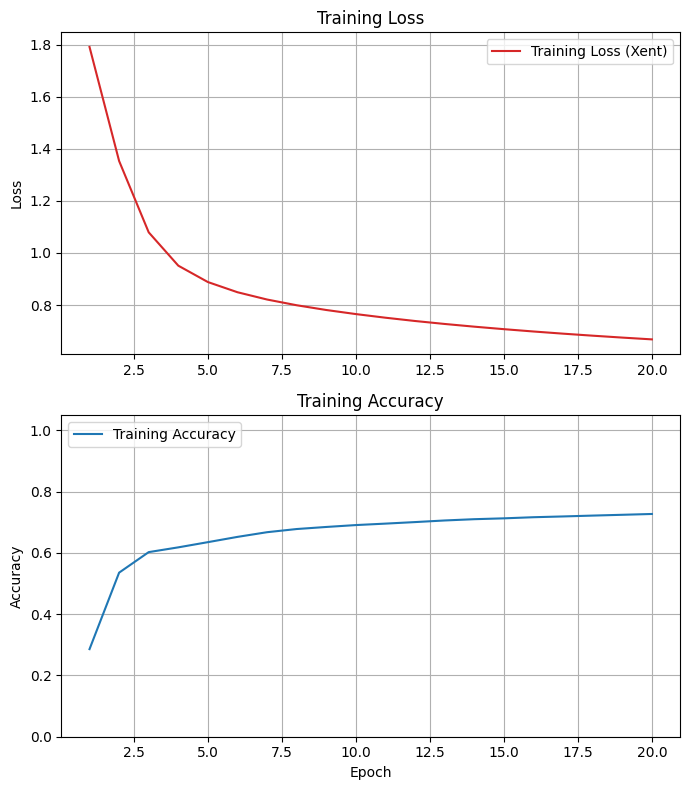

Final Training Loss:     0.6683
Final Training Accuracy: 0.7271
Test loss: 0.6582
Test accuracy: 0.7363


In [36]:
# Your code here
# Part B: Build, compile, train, evaluate (64 -> 32) with ReLU + Softmax

# --- infer #classes for softmax output ---
n_classes = int(np.max(y_train)) + 1  # works if labels are 0..K-1
# If your labels are not 0..K-1, use: n_classes = len(np.unique(y_train))

model = Sequential([
    Input(shape=(X_train_std.shape[1],)),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(n_classes, activation="softmax")
])

model.summary()

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train_std, y_train,
    validation_data=(X_test_std, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

plot_history(history)

# Evaluate on test set (use these variables for graded questions if needed)
test_loss, test_acc = model.evaluate(X_test_std, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


In [37]:
# Set a1a to the final training accuracy at epoch 20
a1a = history.history["accuracy"][-1]


In [38]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a:.4f}')  

a1a = 0.7271


## Problem Two: Batch Sizes

Next, we’ll explore how the **batch size** affects training. .

* Start with the code from Problem One.
* Run **four experiments** using a batch size of 4, 8, 16, and 128, and  displaying the results using `plot_history`.

* Answer the graded questions.

**Note:** Consider using a `for` loop!


Training with batch_size=4
Epoch 1/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5124 - loss: 1.3070 - val_accuracy: 0.6188 - val_loss: 0.9562
Epoch 2/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6434 - loss: 0.8891 - val_accuracy: 0.6789 - val_loss: 0.8086
Epoch 3/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6772 - loss: 0.7996 - val_accuracy: 0.6947 - val_loss: 0.7491
Epoch 4/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6980 - loss: 0.7524 - val_accuracy: 0.7101 - val_loss: 0.7113
Epoch 5/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7116 - loss: 0.7188 - val_accuracy: 0.7207 - val_loss: 0.6835
Epoch 6/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7192 - loss: 0.6928 - val_accuracy: 0.7311 - val_loss: 0.6617
Epoch 7/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7272 - loss: 0.6716 - val_accuracy: 0.7389 - val_loss: 0.6445
Epoch 8/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accura

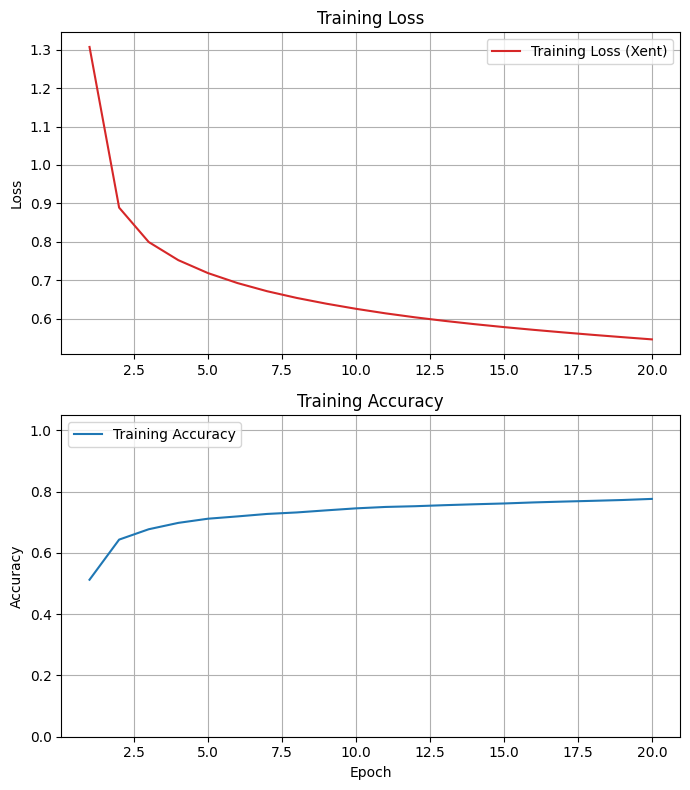

Final Training Loss:     0.5464
Final Training Accuracy: 0.7763
Test loss (bs=4): 0.5450
Test acc  (bs=4): 0.7754

Training with batch_size=8
Epoch 1/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4553 - loss: 1.5266 - val_accuracy: 0.6001 - val_loss: 1.1483
Epoch 2/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6168 - loss: 0.9958 - val_accuracy: 0.6513 - val_loss: 0.8928
Epoch 3/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6529 - loss: 0.8609 - val_accuracy: 0.6768 - val_loss: 0.8099
Epoch 4/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6748 - loss: 0.8038 - val_accuracy: 0.6906 - val_loss: 0.7629
Epoch 5/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6886 - loss: 0.7658 - val_accuracy: 0.7002 - val_loss: 0.7294
Epoch 6/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7001 - loss: 0.7361 - val_accuracy: 0.7155 - val_loss: 0.7034
Epoch 7/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7107 - los

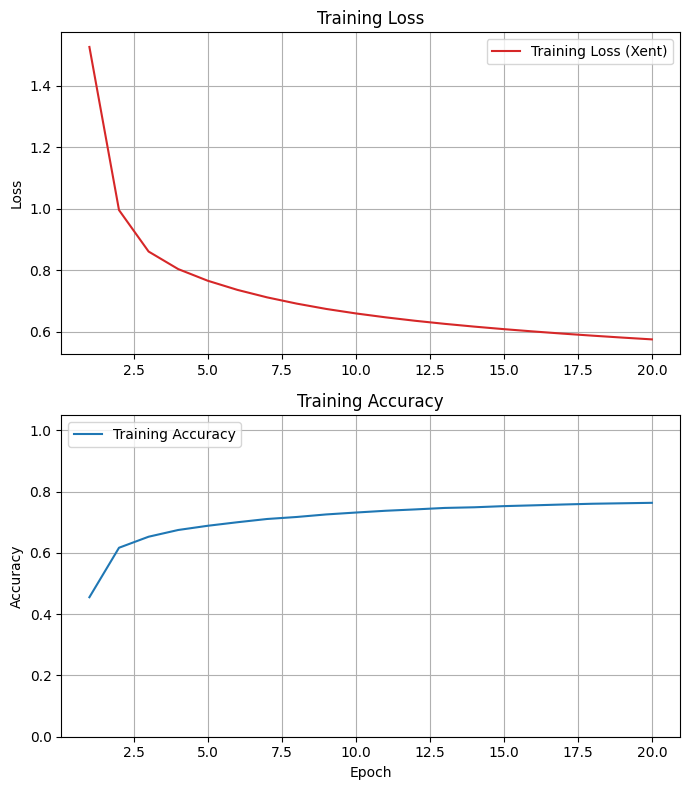

Final Training Loss:     0.5751
Final Training Accuracy: 0.7635
Test loss (bs=8): 0.5692
Test acc  (bs=8): 0.7605

Training with batch_size=16
Epoch 1/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4362 - loss: 1.5962 - val_accuracy: 0.5941 - val_loss: 1.2414
Epoch 2/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6093 - loss: 1.0706 - val_accuracy: 0.6427 - val_loss: 0.9540
Epoch 3/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6416 - loss: 0.9099 - val_accuracy: 0.6693 - val_loss: 0.8555
Epoch 4/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6649 - loss: 0.8429 - val_accuracy: 0.6859 - val_loss: 0.8024
Epoch 5/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6806 - loss: 0.8020 - val_accuracy: 0.6973 - val_loss: 0.7668
Epoch 6/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6926 - loss: 0.7723 - val_accuracy: 0.7059 - val_loss: 0.7399
Epoch 7/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7013 - loss: 0.7486 - v

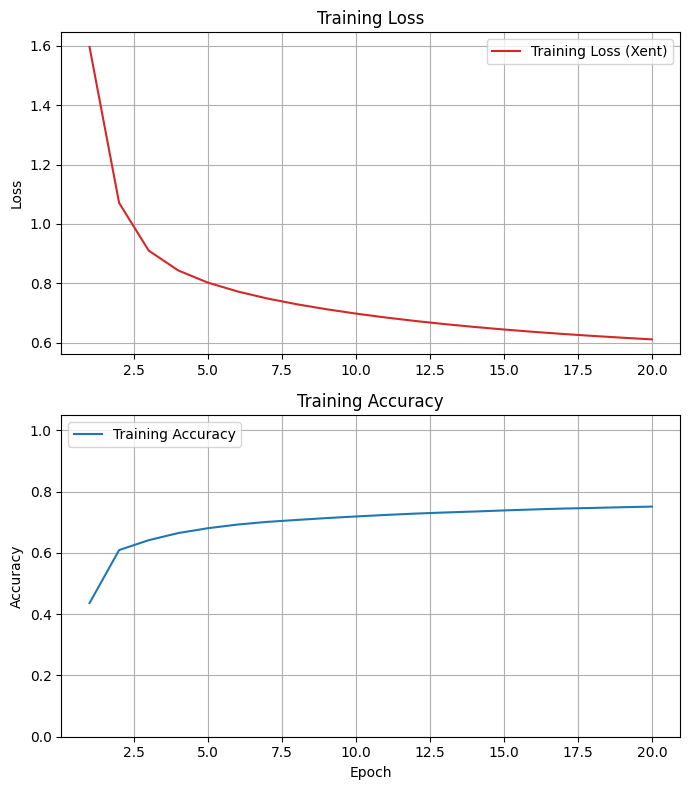

Final Training Loss:     0.6107
Final Training Accuracy: 0.7512
Test loss (bs=16): 0.5953
Test acc  (bs=16): 0.7543

Training with batch_size=128
Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2054 - loss: 1.8974 - val_accuracy: 0.3352 - val_loss: 1.7686
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4055 - loss: 1.6762 - val_accuracy: 0.4789 - val_loss: 1.5666
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5194 - loss: 1.4824 - val_accuracy: 0.5588 - val_loss: 1.3818
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5695 - loss: 1.3084 - val_accuracy: 0.5897 - val_loss: 1.2189
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5959 - loss: 1.1680 - val_accuracy: 0.6121 - val_loss: 1.0980
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6090 - loss: 1.0704 - val_accuracy: 0.6266 - val_loss: 1.0159
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6195 - loss: 1.0041 

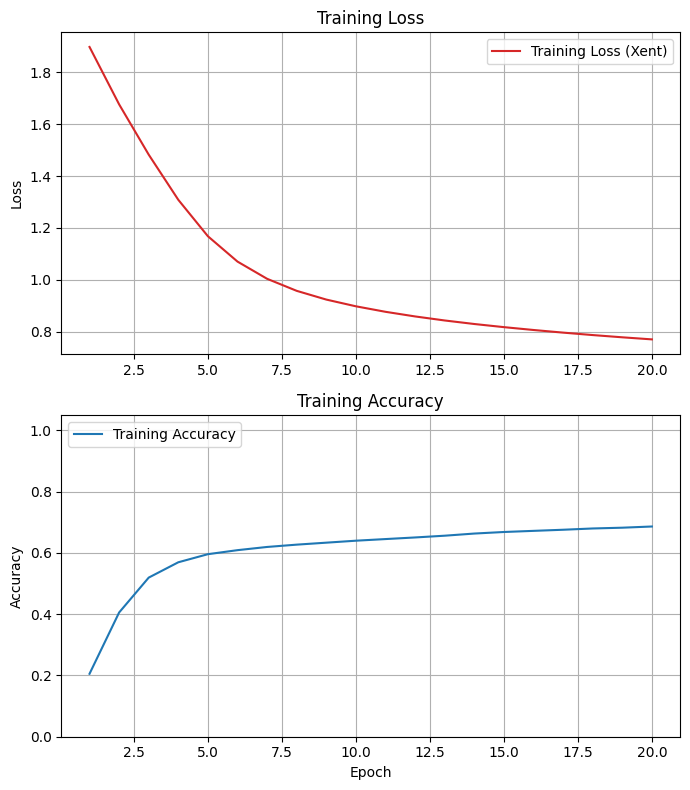

Final Training Loss:     0.7707
Final Training Accuracy: 0.6862
Test loss (bs=128): 0.7462
Test acc  (bs=128): 0.6986


In [39]:
# Your code here
# Problem Two: Batch size experiments (4, 8, 16, 128)

batch_sizes = [4, 8, 16, 128]
histories = {}          # store History objects by batch size
test_results = {}       # store (loss, acc) by batch size

n_classes = int(np.max(y_train)) + 1  # adjust if labels not 0..K-1

for bs in batch_sizes:
    print("\n" + "="*60)
    print(f"Training with batch_size={bs}")
    
    # Rebuild a fresh model each time (important!)
    model_bs = Sequential([
        Input(shape=(X_train_std.shape[1],)),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(n_classes, activation="softmax")
    ])

    model_bs.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    history_bs = model_bs.fit(
        X_train_std, y_train,
        validation_data=(X_test_std, y_test),
        epochs=20,
        batch_size=bs,
        verbose=1
    )

    print(f"Curves for batch_size={bs}")
    plot_history(history_bs)

    loss_bs, acc_bs = model_bs.evaluate(X_test_std, y_test, verbose=0)
    print(f"Test loss (bs={bs}): {loss_bs:.4f}")
    print(f"Test acc  (bs={bs}): {acc_bs:.4f}")

    histories[bs] = history_bs
    test_results[bs] = (loss_bs, acc_bs)


In [40]:
# Set a2a to the batch size which produced the best accuracy score at epoch 20

a2a = max(histories, key=lambda bs: histories[bs].history["accuracy"][-1])


In [41]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a}') 

a2a = 4


In [42]:
# Set a2b to the best accuracy score found

# Best training accuracy at epoch 20 from Problem Two (batch size experiments)
a2b = max(h.history["accuracy"][-1] for h in histories.values())



In [43]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7763


## Problem Three: Learning Rates

Next, we’ll explore how the **learning rate** affects training when using the Adam optimizer.

* Start with the code from **Problem One**.
* Add the `learning_rate` parameter to `Adam`.
* Run **five experiments** using the following values:

        [1e-3, 5e-4, 1e-4,5e-5, 1e-5]

* Display your results using `plot_history` and answer the graded questions.



Training with learning_rate=0.001
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5997 - loss: 1.0218 - val_accuracy: 0.6885 - val_loss: 0.7613
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6964 - loss: 0.7406 - val_accuracy: 0.7322 - val_loss: 0.6703
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7267 - loss: 0.6665 - val_accuracy: 0.7483 - val_loss: 0.6190
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7448 - loss: 0.6221 - val_accuracy: 0.7598 - val_loss: 0.5874
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7573 - loss: 0.5916 - val_accuracy: 0.7660 - val_loss: 0.5657
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7643 - loss: 0.5689 - val_accuracy: 0.7691 - val_loss: 0.5498
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7726 - loss: 0.5506 - val_accuracy: 0.7787 - val_loss: 0.5366
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.778

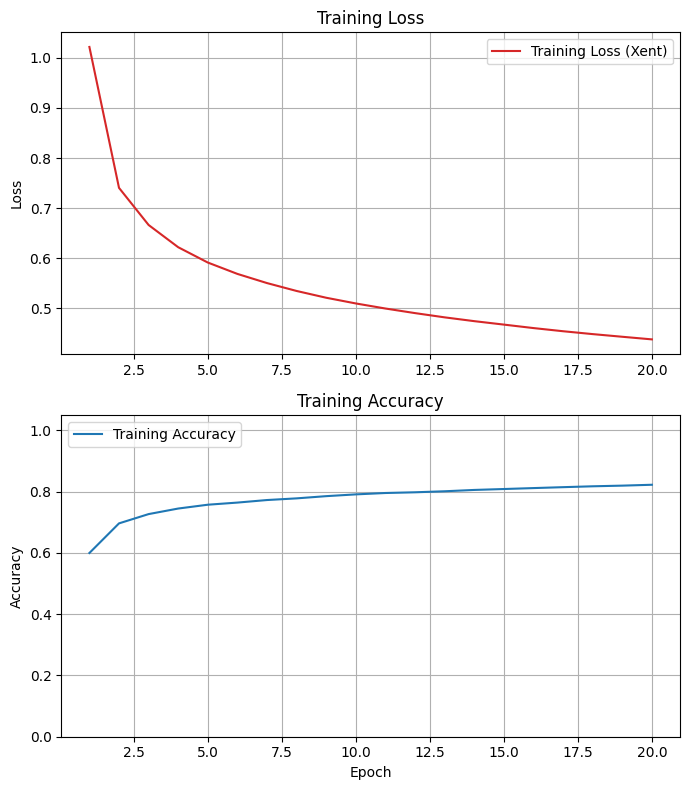

Final Training Loss:     0.4382
Final Training Accuracy: 0.8225
Test loss (lr=0.001): 0.4703
Test acc  (lr=0.001): 0.8164

Training with learning_rate=0.0005
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5567 - loss: 1.1448 - val_accuracy: 0.6609 - val_loss: 0.8513
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6726 - loss: 0.8051 - val_accuracy: 0.7010 - val_loss: 0.7406
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6990 - loss: 0.7325 - val_accuracy: 0.7252 - val_loss: 0.6860
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7173 - loss: 0.6866 - val_accuracy: 0.7371 - val_loss: 0.6498
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7326 - loss: 0.6535 - val_accuracy: 0.7470 - val_loss: 0.6245
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7422 - loss: 0.6288 - val_accuracy: 0.7491 - val_loss: 0.6058
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7487 - l

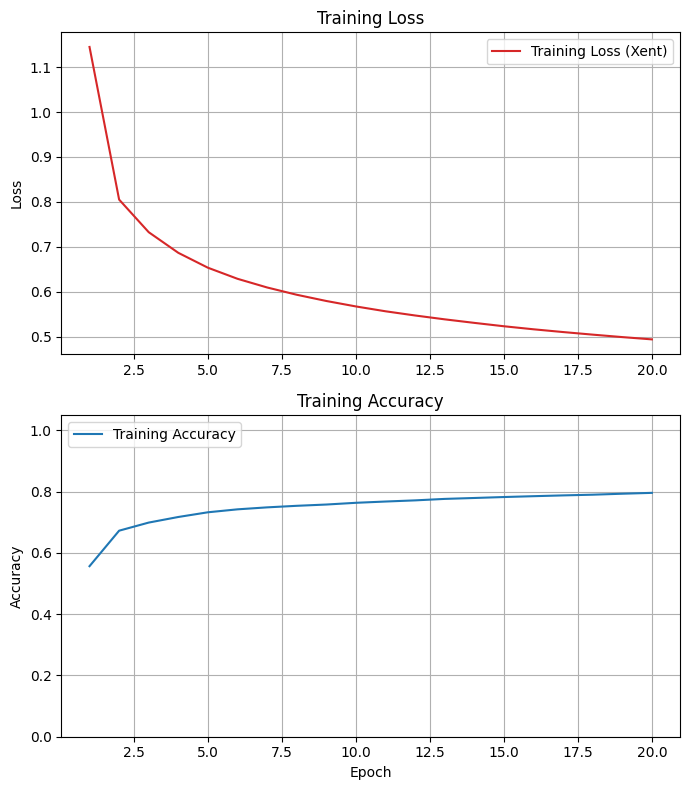

Final Training Loss:     0.4940
Final Training Accuracy: 0.7960
Test loss (lr=0.0005): 0.5063
Test acc  (lr=0.0005): 0.7894

Training with learning_rate=0.0001
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3947 - loss: 1.6771 - val_accuracy: 0.5289 - val_loss: 1.4132
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5546 - loss: 1.2277 - val_accuracy: 0.5790 - val_loss: 1.0992
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5857 - loss: 1.0225 - val_accuracy: 0.6069 - val_loss: 0.9687
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6120 - loss: 0.9337 - val_accuracy: 0.6310 - val_loss: 0.9008
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6343 - loss: 0.8830 - val_accuracy: 0.6539 - val_loss: 0.8570
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6502 - loss: 0.8482 - val_accuracy: 0.6726 - val_loss: 0.8244
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6609 -

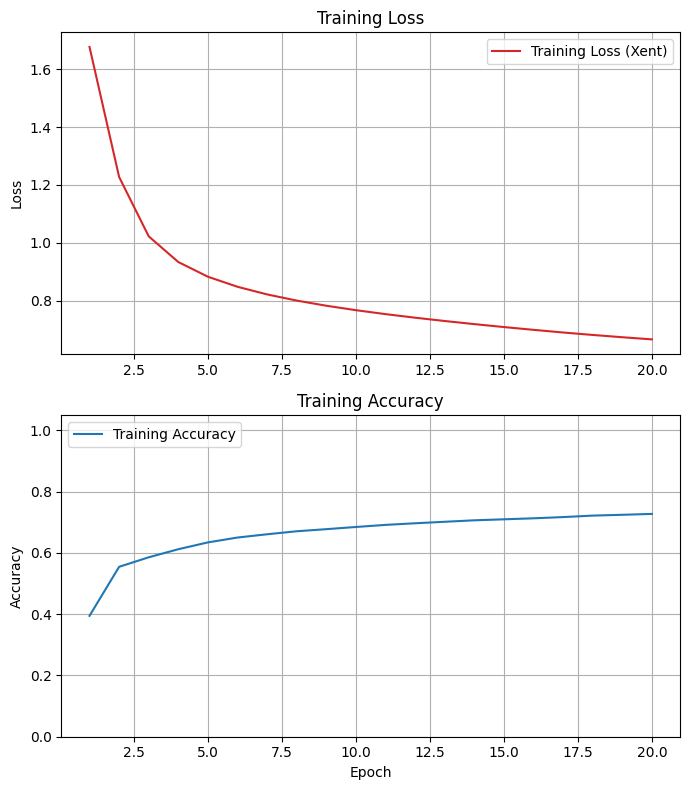

Final Training Loss:     0.6664
Final Training Accuracy: 0.7273
Test loss (lr=0.0001): 0.6522
Test acc  (lr=0.0001): 0.7343

Training with learning_rate=5e-05
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2653 - loss: 1.9882 - val_accuracy: 0.3596 - val_loss: 1.8117
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4200 - loss: 1.6674 - val_accuracy: 0.4912 - val_loss: 1.5337
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5160 - loss: 1.4155 - val_accuracy: 0.5465 - val_loss: 1.3126
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5668 - loss: 1.2305 - val_accuracy: 0.5783 - val_loss: 1.1592
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5902 - loss: 1.1073 - val_accuracy: 0.6006 - val_loss: 1.0596
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6014 - loss: 1.0274 - val_accuracy: 0.6149 - val_loss: 0.9927
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6123 - 

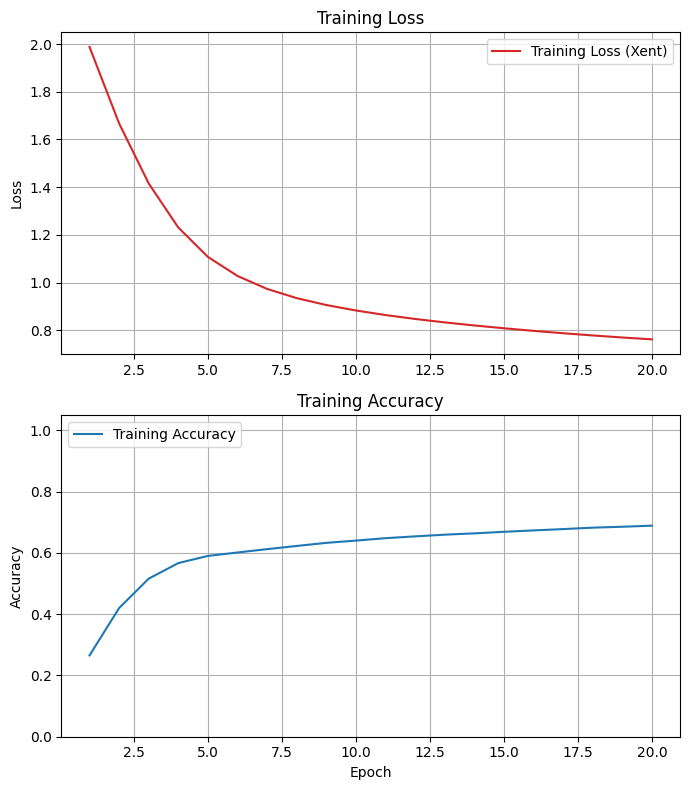

Final Training Loss:     0.7614
Final Training Accuracy: 0.6889
Test loss (lr=5e-05): 0.7467
Test acc  (lr=5e-05): 0.6989

Training with learning_rate=1e-05
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1625 - loss: 2.0801 - val_accuracy: 0.1867 - val_loss: 2.0290
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2081 - loss: 1.9839 - val_accuracy: 0.2397 - val_loss: 1.9443
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2507 - loss: 1.9063 - val_accuracy: 0.2702 - val_loss: 1.8741
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2826 - loss: 1.8403 - val_accuracy: 0.2985 - val_loss: 1.8130
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3201 - loss: 1.7817 - val_accuracy: 0.3430 - val_loss: 1.7574
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3766 - loss: 1.7270 - val_accuracy: 0.3968 - val_loss: 1.7045
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4235 - lo

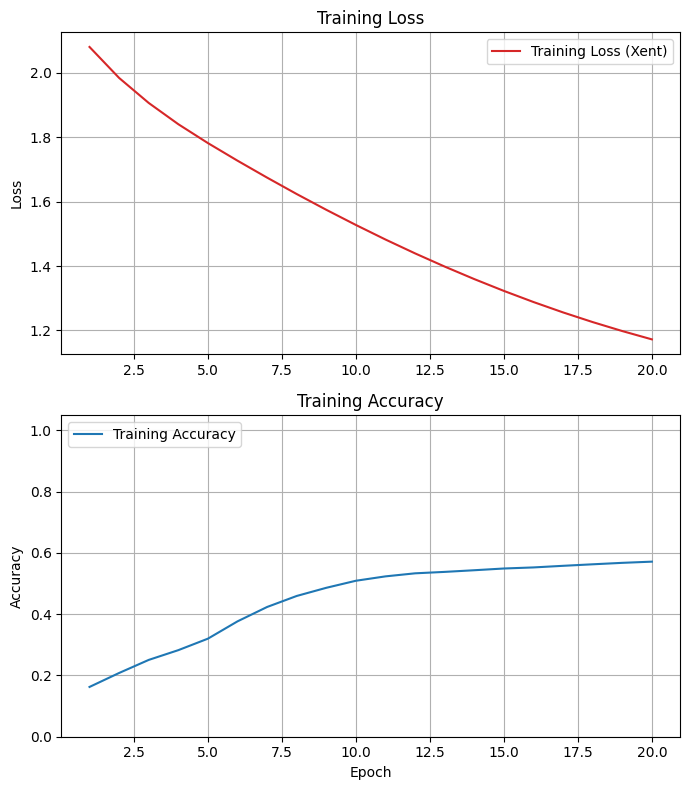

Final Training Loss:     1.1723
Final Training Accuracy: 0.5715
Test loss (lr=1e-05): 1.1590
Test acc  (lr=1e-05): 0.5785


In [44]:
# Your code here
# Problem Three: Learning rate experiments for Adam

learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
lr_histories = {}
lr_test_results = {}

n_classes = int(np.max(y_train)) + 1  # adjust if labels not 0..K-1

for lr in learning_rates:
    print("\n" + "="*60)
    print(f"Training with learning_rate={lr}")

    # Fresh model each run
    model_lr = Sequential([
        Input(shape=(X_train_std.shape[1],)),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(n_classes, activation="softmax")
    ])

    model_lr.compile(
        optimizer=Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    history_lr = model_lr.fit(
        X_train_std, y_train,
        validation_data=(X_test_std, y_test),
        epochs=20,
        batch_size=32,
        verbose=1
    )

    print(f"Curves for learning_rate={lr}")
    plot_history(history_lr)

    loss_lr, acc_lr = model_lr.evaluate(X_test_std, y_test, verbose=0)
    print(f"Test loss (lr={lr}): {loss_lr:.4f}")
    print(f"Test acc  (lr={lr}): {acc_lr:.4f}")

    lr_histories[lr] = history_lr
    lr_test_results[lr] = (loss_lr, acc_lr)



In [45]:
# Set a3a to the learning rate which produces the best (largest) accuracy at epoch 20

a3a = max(lr_histories, key=lambda lr: lr_histories[lr].history["accuracy"][-1])


In [46]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a:.4f}') 

a3a = 0.0010


In [47]:
# Set a3b to the accuracy found by the best learning rate

a3b = lr_histories[a3a].history["accuracy"][-1]


In [48]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.8225


## Problem Four: Cosine Decay Learning Rate Scheduling

In this problem we'll gain some experience using the Cosine Decay learning rate scheduler with Adam. 

* Start with the code from **Problem One**.
* Define a `CosineDecay` learning rate scheduler (see `Week02_Coding.ipynb` for details)
* Use the scheduler with the Adam optimzier
* Run **five experiments** using the following values for `initial_learning_rate`:

        [1e-2, 5e-3, 1e-3,5e-4, 1e-4]

* Display your results using `plot_history` and answer the graded questions.


Training with CosineDecay initial_learning_rate=0.01
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6565 - loss: 0.8304 - val_accuracy: 0.7057 - val_loss: 0.6869
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7167 - loss: 0.6760 - val_accuracy: 0.7296 - val_loss: 0.6444
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7358 - loss: 0.6250 - val_accuracy: 0.7512 - val_loss: 0.6114
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7581 - loss: 0.5880 - val_accuracy: 0.7561 - val_loss: 0.5837
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7684 - loss: 0.5583 - val_accuracy: 0.7787 - val_loss: 0.5511
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7783 - loss: 0.5380 - val_accuracy: 0.7764 - val_loss: 0.5443
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7902 - loss: 0.5150 - val_accuracy: 0.7868 - val_loss: 0.5352
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/ste

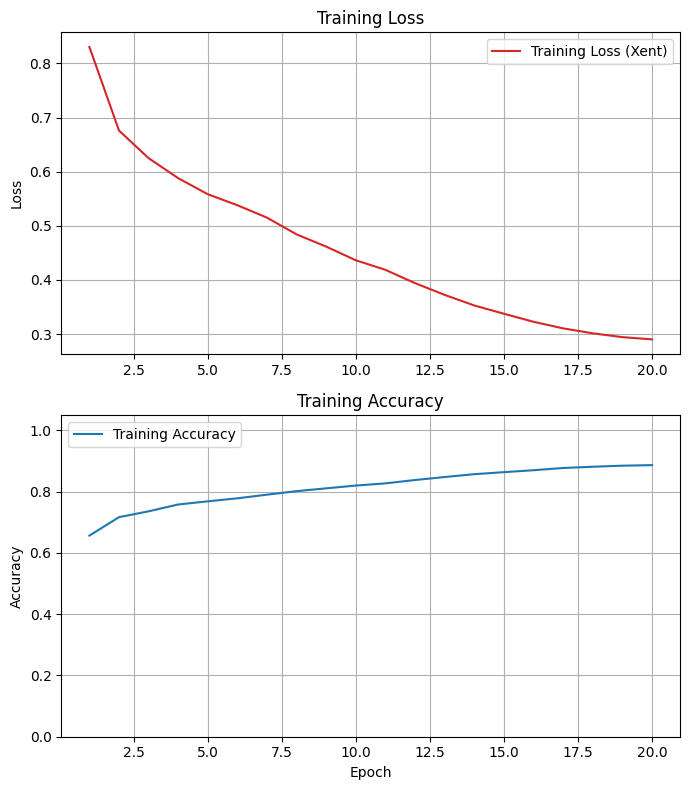

Final Training Loss:     0.2902
Final Training Accuracy: 0.8865
Test loss (init_lr=0.01): 0.4178
Test acc  (init_lr=0.01): 0.8422

Training with CosineDecay initial_learning_rate=0.005
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6559 - loss: 0.8414 - val_accuracy: 0.7298 - val_loss: 0.6580
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7237 - loss: 0.6493 - val_accuracy: 0.7475 - val_loss: 0.5987
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7502 - loss: 0.5923 - val_accuracy: 0.7496 - val_loss: 0.5747
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7658 - loss: 0.5551 - val_accuracy: 0.7652 - val_loss: 0.5482
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7824 - loss: 0.5272 - val_accuracy: 0.7774 - val_loss: 0.5269
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7924 - loss: 0.5029 - val_accuracy: 0.7889 - val_loss: 0.5088
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/

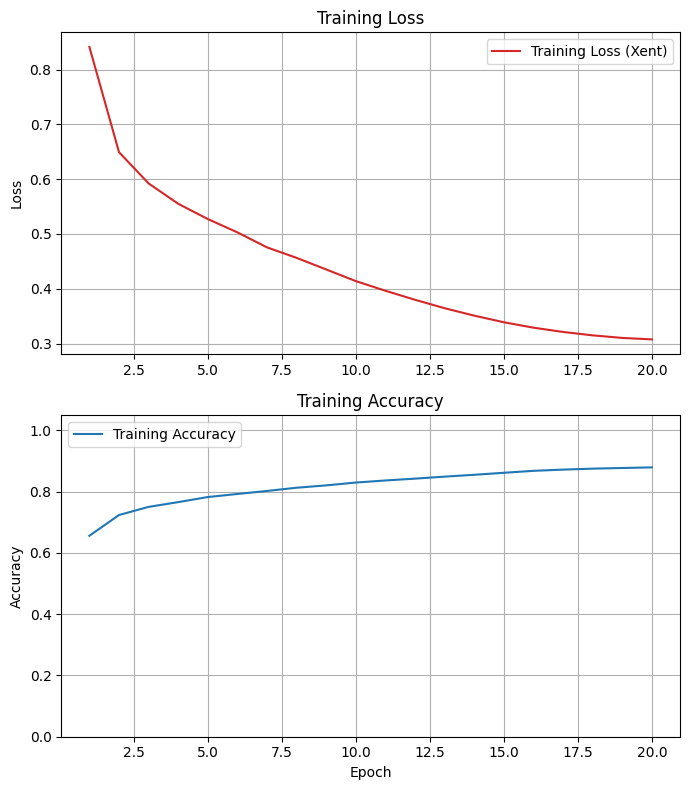

Final Training Loss:     0.3075
Final Training Accuracy: 0.8792
Test loss (init_lr=0.005): 0.4161
Test acc  (init_lr=0.005): 0.8424

Training with CosineDecay initial_learning_rate=0.001
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5966 - loss: 1.0356 - val_accuracy: 0.6851 - val_loss: 0.7713
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6871 - loss: 0.7490 - val_accuracy: 0.7197 - val_loss: 0.6788
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7170 - loss: 0.6761 - val_accuracy: 0.7447 - val_loss: 0.6275
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7347 - loss: 0.6327 - val_accuracy: 0.7559 - val_loss: 0.5973
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7465 - loss: 0.6033 - val_accuracy: 0.7663 - val_loss: 0.5745
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7571 - loss: 0.5808 - val_accuracy: 0.7735 - val_loss: 0.5579
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1m

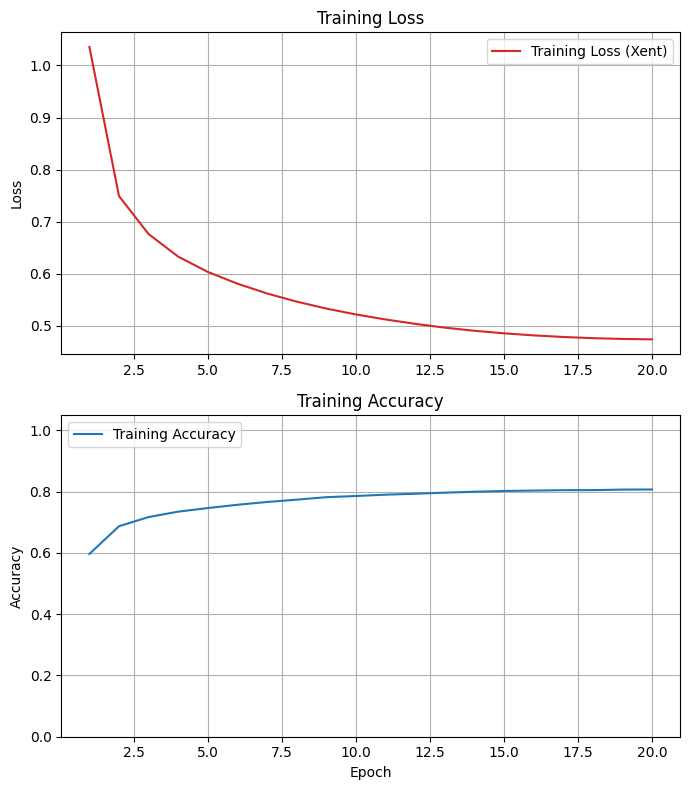

Final Training Loss:     0.4738
Final Training Accuracy: 0.8071
Test loss (init_lr=0.001): 0.4988
Test acc  (init_lr=0.001): 0.8037

Training with CosineDecay initial_learning_rate=0.0005
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5438 - loss: 1.2011 - val_accuracy: 0.6547 - val_loss: 0.8740
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6679 - loss: 0.8119 - val_accuracy: 0.6971 - val_loss: 0.7461
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6972 - loss: 0.7356 - val_accuracy: 0.7176 - val_loss: 0.6891
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7167 - loss: 0.6920 - val_accuracy: 0.7306 - val_loss: 0.6538
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7305 - loss: 0.6609 - val_accuracy: 0.7384 - val_loss: 0.6292
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7424 - loss: 0.6373 - val_accuracy: 0.7436 - val_loss: 0.6107
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1

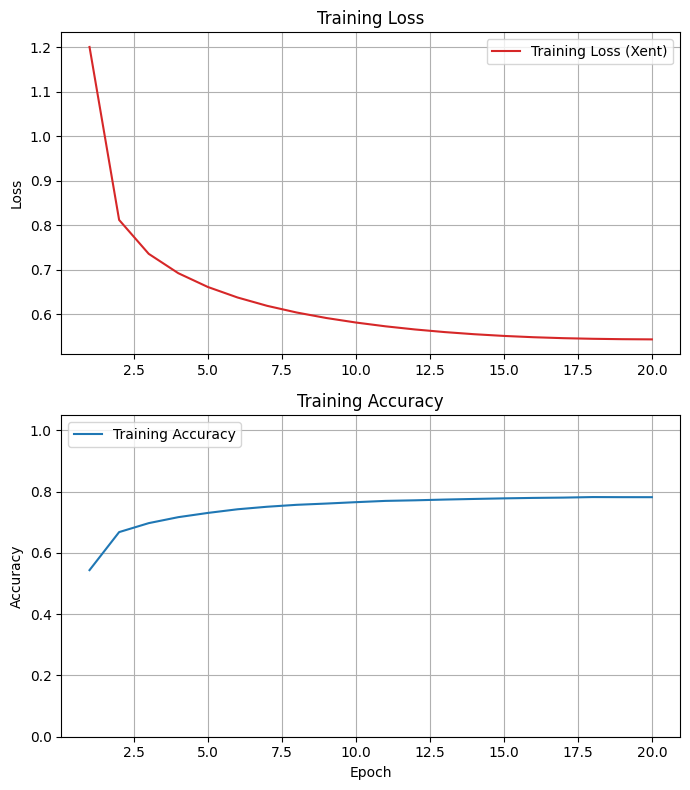

Final Training Loss:     0.5431
Final Training Accuracy: 0.7819
Test loss (init_lr=0.0005): 0.5425
Test acc  (init_lr=0.0005): 0.7845

Training with CosineDecay initial_learning_rate=0.0001
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3675 - loss: 1.7110 - val_accuracy: 0.4945 - val_loss: 1.4410
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5543 - loss: 1.2431 - val_accuracy: 0.5777 - val_loss: 1.1165
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6050 - loss: 1.0243 - val_accuracy: 0.6134 - val_loss: 0.9759
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6315 - loss: 0.9300 - val_accuracy: 0.6430 - val_loss: 0.9057
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6483 - loss: 0.8795 - val_accuracy: 0.6563 - val_loss: 0.8625
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6596 - loss: 0.8462 - val_accuracy: 0.6641 - val_loss: 0.8319
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s

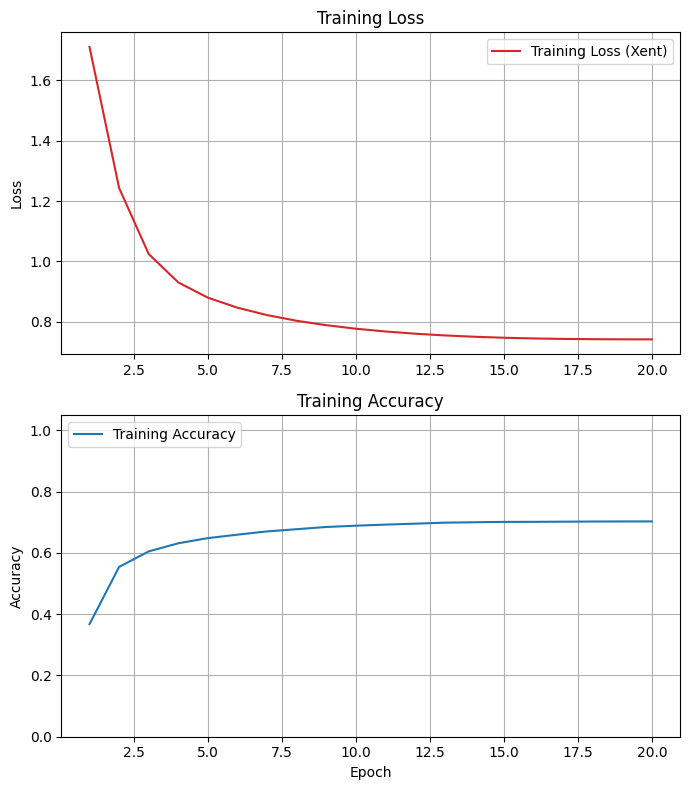

Final Training Loss:     0.7412
Final Training Accuracy: 0.7028
Test loss (init_lr=0.0001): 0.7375
Test acc  (init_lr=0.0001): 0.7031


In [49]:
# Your code here
# Problem Four: CosineDecay scheduling experiments with Adam

initial_lrs = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
cos_histories = {}
cos_test_results = {}

n_classes = int(np.max(y_train)) + 1  # adjust if labels not 0..K-1

# A sensible default: decay over the whole training run
steps_per_epoch = int(np.ceil(len(X_train_std) / 32))
decay_steps = steps_per_epoch * 20   # 20 epochs total

for init_lr in initial_lrs:
    print("\n" + "="*60)
    print(f"Training with CosineDecay initial_learning_rate={init_lr}")

    lr_schedule = CosineDecay(
        initial_learning_rate=init_lr,
        decay_steps=decay_steps
        # alpha=0.0  # optional: final_lr = alpha * initial_lr
    )

    model_cos = Sequential([
        Input(shape=(X_train_std.shape[1],)),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(n_classes, activation="softmax")
    ])

    model_cos.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    history_cos = model_cos.fit(
        X_train_std, y_train,
        validation_data=(X_test_std, y_test),
        epochs=20,
        batch_size=32,
        verbose=1
    )

    print(f"Curves for CosineDecay initial_learning_rate={init_lr}")
    plot_history(history_cos)

    loss_cos, acc_cos = model_cos.evaluate(X_test_std, y_test, verbose=0)
    print(f"Test loss (init_lr={init_lr}): {loss_cos:.4f}")
    print(f"Test acc  (init_lr={init_lr}): {acc_cos:.4f}")

    cos_histories[init_lr] = history_cos
    cos_test_results[init_lr] = (loss_cos, acc_cos)



In [50]:
# Set a4a to the initial learning rate which produced the best accuracy

a4a = max(cos_histories, key=lambda lr: cos_histories[lr].history["accuracy"][-1])


In [51]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a:.4f}') 

a4a = 0.0100


In [52]:
# Set a4b to the best accuracy found

a4b = cos_histories[a4a].history["accuracy"][-1]


In [53]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.8865


## Problem Five: Find the best model and run on the test set

In this final problem, you must consider all the experiments you've done and pick the
set of training hyperparameters which gives you the best accuracy after 20 epochs. Do not change the model architecture. 

Your choices are:

- Which batch size?
- Cosine Decay or constant learning rate?
    - If Cosine Decay, which initial learning rate?
    - If not, which constant learning rate?

* Display your results using `plot_history`
* Run your best model on the test set
* Answer the graded questions.


**OPTIONAL: change the model architecture (but use only dense layers) and try other learning rate schedulers (exponential, step, etc.)**

Best batch size (Problem 2): 4 train acc: 0.7763115167617798
Best constant LR (Problem 3): 0.001 train acc: 0.8224663734436035
Best cosine init LR (Problem 4): 0.01 train acc: 0.8864980936050415

OVERALL BEST: cosine {'batch_size': 32, 'schedule': 'cosine', 'init_lr': 0.01} train acc: 0.8864980936050415


Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6528 - loss: 0.8350 - val_accuracy: 0.7085 - val_loss: 0.6894
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7198 - loss: 0.6783 - val_accuracy: 0.7371 - val_loss: 0.6282
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7404 - loss: 0.6227 - val_accuracy: 0.7652 - val_loss: 0.5662
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7556 - loss: 0.5917 - val_accuracy: 0.7673 - val_loss: 0.5584
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7667 - loss: 0.5607 - val_accuracy: 0.7803 - val_loss: 0.5294
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7783 - loss: 0.5361 - val_accuracy: 0.7839 - val_loss: 0.5237
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7872 - loss: 0.5139 - val_accuracy: 0.7917 - val_loss: 0.5100
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7992 - loss: 0.4851 - val_accuracy: 0.

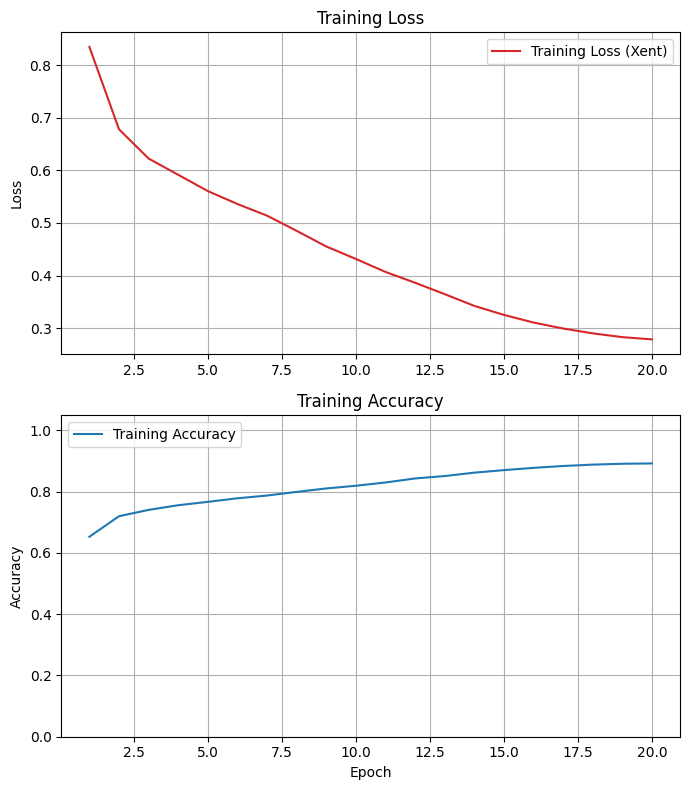

Final Training Loss:     0.2785
Final Training Accuracy: 0.8921
Best model test loss: 0.4277
Best model test accuracy: 0.8440


In [54]:
# Your code here -- add as many cells as you need

# =========================
# Problem Five: Pick best hyperparameters across ALL experiments,
# retrain best model (same architecture), plot_history, evaluate on test.
# =========================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
import numpy as np

# --- helper: final training accuracy from a History object ---
def final_train_acc(hist):
    return hist.history["accuracy"][-1]

# --- 1) Find best from Problem Two (batch size runs; uses constant lr=1e-4 in your code) ---
best_bs = max(histories, key=lambda bs: final_train_acc(histories[bs]))
best_bs_acc = final_train_acc(histories[best_bs])

# --- 2) Find best from Problem Three (constant learning-rate runs; uses batch_size=32) ---
best_lr = max(lr_histories, key=lambda lr: final_train_acc(lr_histories[lr]))
best_lr_acc = final_train_acc(lr_histories[best_lr])

# --- 3) Find best from Problem Four (cosine-decay runs; uses batch_size=32) ---
best_cos_init = max(cos_histories, key=lambda lr: final_train_acc(cos_histories[lr]))
best_cos_acc = final_train_acc(cos_histories[best_cos_init])

print("Best batch size (Problem 2):", best_bs, "train acc:", best_bs_acc)
print("Best constant LR (Problem 3):", best_lr, "train acc:", best_lr_acc)
print("Best cosine init LR (Problem 4):", best_cos_init, "train acc:", best_cos_acc)

# --- 4) Choose the overall best option ---
candidates = [
    ("batch_size", {"batch_size": best_bs, "schedule": "constant", "lr": 1e-4}, best_bs_acc),
    ("const_lr",   {"batch_size": 32,     "schedule": "constant", "lr": best_lr}, best_lr_acc),
    ("cosine",     {"batch_size": 32,     "schedule": "cosine",   "init_lr": best_cos_init}, best_cos_acc),
]
best_name, best_cfg, best_acc = max(candidates, key=lambda t: t[2])

print("\nOVERALL BEST:", best_name, best_cfg, "train acc:", best_acc)

# --- 5) Retrain best model from scratch using that config ---
n_classes = int(np.max(y_train)) + 1  # adjust if labels not 0..K-1

# CosineDecay decay_steps over full training run (20 epochs)
steps_per_epoch = int(np.ceil(len(X_train_std) / best_cfg["batch_size"]))
decay_steps = steps_per_epoch * 20

if best_cfg.get("schedule") == "cosine":
    lr_schedule = CosineDecay(
        initial_learning_rate=best_cfg["init_lr"],
        decay_steps=decay_steps
    )
    optimizer = Adam(learning_rate=lr_schedule)
else:
    optimizer = Adam(learning_rate=best_cfg["lr"])

best_model = Sequential([
    Input(shape=(X_train_std.shape[1],)),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(n_classes, activation="softmax")
])

best_model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

best_history = best_model.fit(
    X_train_std, y_train,
    validation_data=(X_test_std, y_test),
    epochs=20,
    batch_size=best_cfg["batch_size"],
    verbose=1
)

plot_history(best_history)

# --- 6) Final evaluation on the test set ---
best_test_loss, best_test_acc = best_model.evaluate(X_test_std, y_test, verbose=0)
print(f"Best model test loss: {best_test_loss:.4f}")
print(f"Best model test accuracy: {best_test_acc:.4f}")

# If your notebook asks for graded variables, use expressions like these:
a5a = best_cfg["batch_size"]
# a5b = (best_cfg.get("init_lr") if best_cfg["schedule"]=="cosine" else best_cfg["lr"])
# a5c = best_history.history["accuracy"][-1]
# a5d = best_test_acc


In [55]:
# Set a5a to the best training accuracy found by your best model

a5a = best_history.history["accuracy"][-1]

In [56]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5a = {a5a:.4f}') 

a5a = 0.8921


In [57]:
# Set a5b to the test accuracy found by your best model

a5b = best_test_acc


In [58]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5b = {a5b:.4f}') 

a5b = 0.8440


## Reflection Questions (ungraded)

1. We trained on a perfectly balanced \~3.3% subset.
   If we *increase the subset size* (still balanced), how would you expect (a) training time, (b) the best **batch size**, and (c) the best **learning rate** to change? Why?

2. **Batch size trade-offs.**
   With epochs fixed, why do smaller batches often generalize better on tabular data than large batches? What would you change if you *must* use a large batch?

3. **More epochs, same LR.**
    If you doubled the number of epochs (no other changes), what do you think would happen to train loss/acc and test acc? 

4. **Epochs vs. LR.**
   It is natural to think that there is an inverse relationship between the number of epochs and learning rate: if you move more slowly, it will take you longer to reach your goal. Does this seem true given what we have seen in the experiments with learning rate?

# Appendix:  Forest Cover Type (Covertype) — Dataset Overview

This dataset pairs **cartographic features** of 30×30 m land plots with the **dominant tree cover type**. Your task is to predict the cover type from terrain and soil indicators—an archetypal **multi-class classification** problem on tabular data.

**At a glance**

* **Samples:** 581,012 original; we’ll use a **balanced subset** (e.g., 2747 per class) for faster, fairer training.
* **Features (54 total):**

  * **10 continuous:** elevation, aspect, slope, distances to hydrology/roads/fire points, and hillshade at 9 AM/noon/3 PM.
  * **44 binary:** **4 Wilderness\_Area** flags and **40 Soil\_Type** one-hot indicators.
* **Target (7 classes):** Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, Krummholz.

**Why it’s useful here**

* Realistic, **tabular** data with mixed feature types.
* Clear demonstration of **scaling** (continuous features) vs. **binary indicators**.
* Originally **imbalanced**, which motivates mindful evaluation (we avoid this by using a balanced subset).


Shape: (19229, 55)

Class distribution:
 Cover_Type
3    0.142857
2    0.142857
6    0.142857
5    0.142857
4    0.142857
1    0.142857
0    0.142857
Name: proportion, dtype: float64


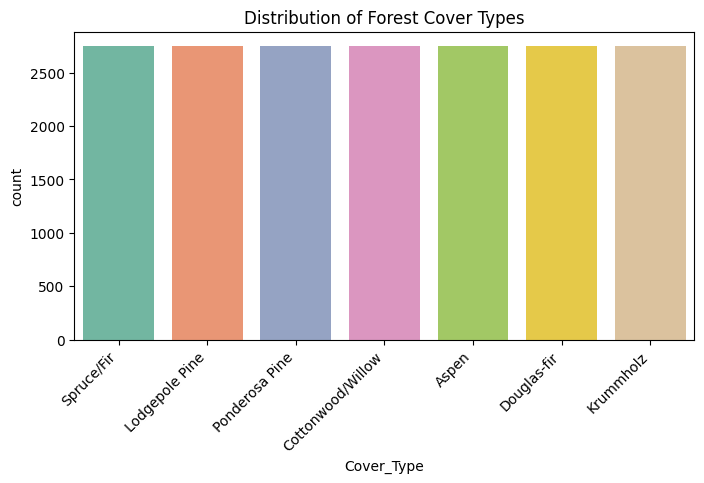

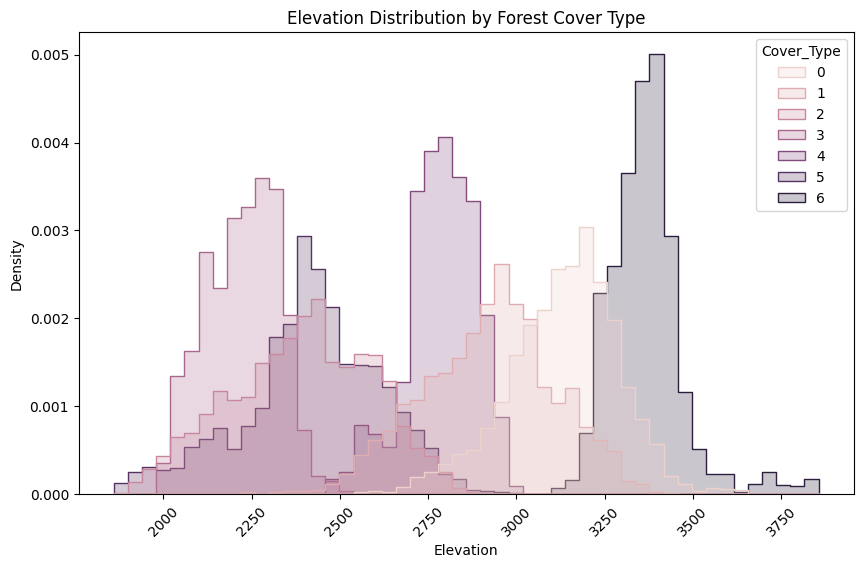

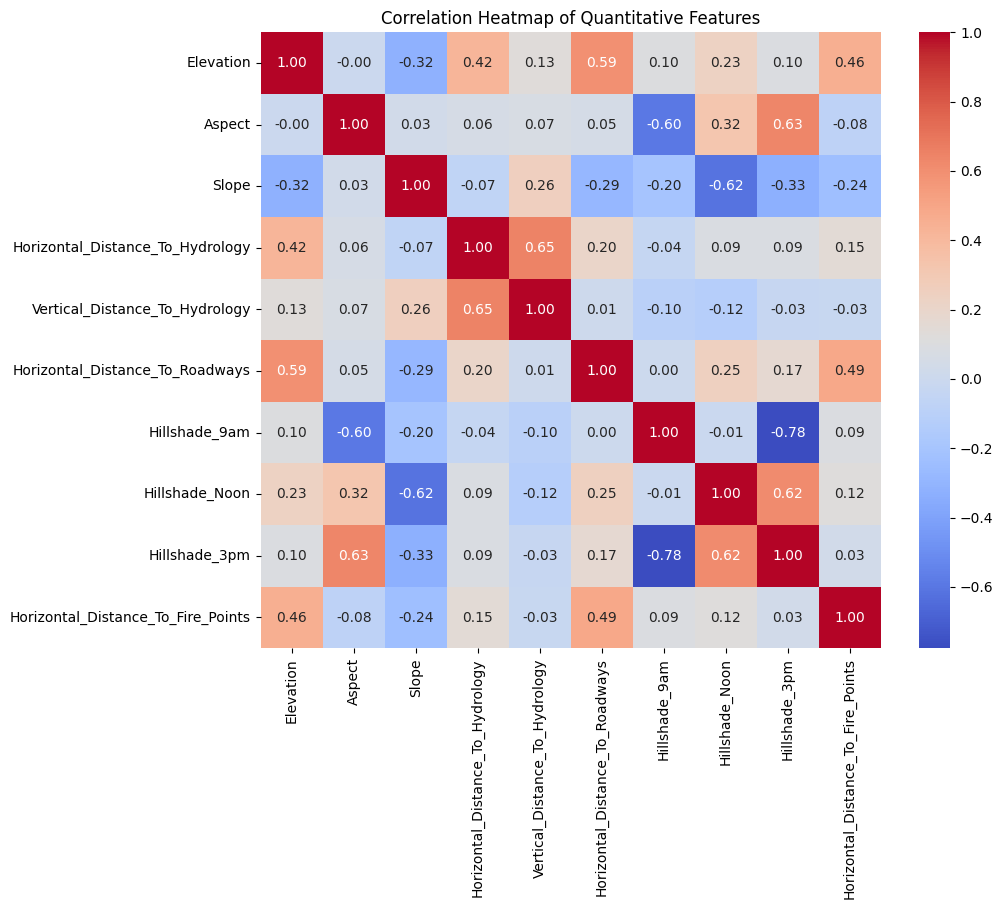

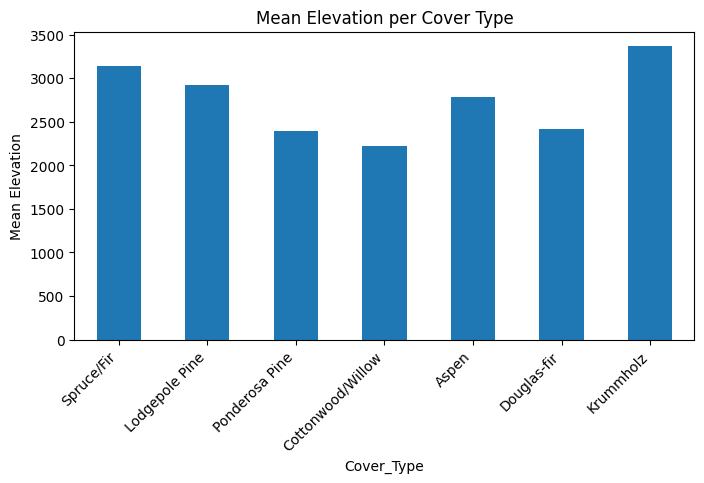

In [59]:
# Attach feature + class names
quant_features = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]
wilderness_features = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_features = [f"Soil_Type{i}" for i in range(1, 41)]

feature_names = quant_features + wilderness_features + soil_features
class_names = [
    "Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine",
    "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"
]

# Create dataframe from your subset
df = pd.DataFrame(X_sub, columns=feature_names)
df["Cover_Type"] = y_sub

# 1. Basic info
print("Shape:", df.shape)
print("\nClass distribution:\n", df["Cover_Type"].value_counts(normalize=True))

# 2. Class distribution plot
plt.figure(figsize=(8,4))
sns.countplot(x="Cover_Type", hue="Cover_Type", data=df, palette="Set2", legend=False)
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.title("Distribution of Forest Cover Types")
plt.show()

# 3. Elevation distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="Elevation", hue="Cover_Type",
             bins=50, element="step", stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title("Elevation Distribution by Forest Cover Type")
plt.show()

# 4. Correlation heatmap (quantitative features only)
plt.figure(figsize=(10,8))
corr = df[quant_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Quantitative Features")
plt.show()

# 5. Mean elevation per cover type
df.groupby("Cover_Type")["Elevation"].mean().plot(kind="bar", figsize=(8,4))
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.ylabel("Mean Elevation")
plt.title("Mean Elevation per Cover Type")
plt.show()
